# <center> <span style='color:Darck'>---Speech recognition for isolated words---</span> <center>

# Introduction

## Feature Extraction
Feature extraction is the method of transforming the input data into a set of features which represents as closely as possible the input data. Audio feature extraction use Digital Signal Processing techniques to convert the audio signals into numerical feature sets which can then be used for training our machine learning models.

## MFCC

MFCC stands for mel-frequency cepstral coefficients. They were introduced by Davis and Mermelstein in the 1980's. These are the most commonly used features in automatic speech recognition. MFCCs are derived from a type of cepstral representation of the audio clip. A cepstrum is the result of taking the inverse fourier transform of the logarithm of the estimated spectrum of the signal. The power cepstrum in particular finds applications in the analysis of human speech. The main difference between the MFC and cepstrum is that in MFC, equal spacing of the frequency bands takes place which approximates the human auditory system’s response more closely. 


<img src="images/MFCC.png" width="900"> 

<center>  Block diagram for the feature extraction process applying MFCC algorithm

The speech signal varies over time. For this reason, it must be divided into frames of short duration (typically 20 to 30 ms) where the sound signal can be considered quasi-stationary, with a shift step between two successive frames of the order of 10 ms.

## Import library

In [138]:
import doctest
import struct
import wave
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy import fft
import IPython.display as ipd
import os
import pandas as pd 

## Useful functions

In [139]:
def readwav(fname):
    """
    Parameters
    ----------
    fname : str
        The filename of the wave file to process

    Returns
    -------
    
    (x, fs) : tuple
    
    x : np.array
        The 1-dim. PCM audio signal

    fs : int
        The sampling frequency
    """
    with wave.open(fname) as wav:
        n = wav.getnframes()
        frames = wav.readframes(n)
        x = struct.unpack("h" * n, frames)
        fs = wav.getframerate()
    return np.array(x), fs

Test the readwav fonction

In [140]:
ipd.Audio("digits/train/ae_1a.wav")

In [141]:
test=readwav("digits/train/ae_1a.wav")
fs=test[-1]
print(len(test[0]))
print(fs*0.001)

6964
8.0


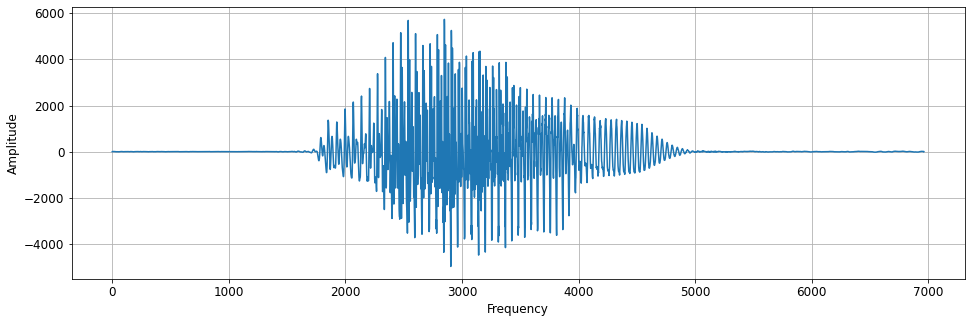

In [142]:
plt.figure(figsize=(16, 5))
plt.plot(test[0])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Mel Scale: Corresponds to an approximation of the psychological sensation of pitch of a sound.

Hertz to mel conversion is computed according to:
$$
\operatorname{mel}(f)=2595 * \log _{10}\left(\frac{1+f}{700}\right)
$$

In [143]:
def mel(f):
    """
    Frequency converter from Hz to Mel

    Parameters
    ----------
    f : int, float or np.array
        The frequency (Hz)

    Returns
    -------
    mel : float or np.array
        The frequency (Mel)

    Examples
    --------
    >>> x = np.linspace(200, 4000, 20)
    >>> with np.printoptions(precision=2):
    ...     print(mel(x))
    [  283.23  509.38  697.65  858.93  999.99 1125.34 ... 2146.06]
    """
 
    return 2595*np.log10(1+f/700)


def hertz(m):
    """
    Frequency converter from Mel to Hz

    Parameters
    ----------
    mel : int, float or np.array
        The frequency (Mel)

    Returns
    -------
    f : float or np.array
        The frequency (Hz)

    Examples
    --------
    >>> x = np.linspace(200, 2000, 20)
    >>> with np.printoptions(precision=2):
    ...     print(hertz(x))
    [  135.93  209.24  288.97  375.7   470.04  572.64 ... 3428.68]
    """
    return 700 * (10**(m/2595)-1)

Test the convertion

In [144]:
x1 = np.linspace(200, 4000, 20)
x2 = np.linspace(200, 2000, 20)
print('Frequency converter from Hz to Mel \n')
with np.printoptions(precision=2):
        print(mel(x1))
print('\n')
print('Frequency converter from Mel to Hz \n')
with np.printoptions(precision=2):
        print(hertz(x2))        

Frequency converter from Hz to Mel 

[ 283.23  509.38  697.65  858.93  999.99 1125.34 1238.13 1340.65 1434.62
 1521.36 1601.89 1677.05 1747.51 1813.83 1876.45 1935.78 1992.14 2045.82
 2097.06 2146.06]


Frequency converter from Mel to Hz 

[ 135.93  209.24  288.97  375.7   470.04  572.64  684.25  805.64  937.68
 1081.3  1237.51 1407.42 1592.23 1793.25 2011.9  2249.72 2508.4  2789.76
 3095.8  3428.68]


A plots of pitch mel-scale versus hertz-scale

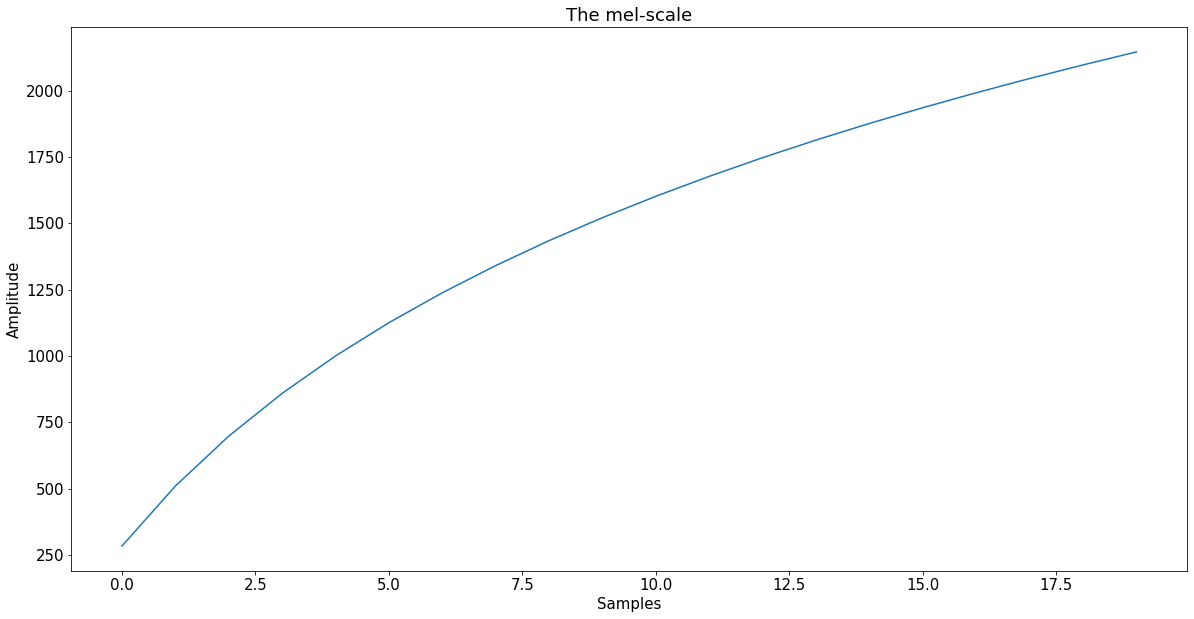

In [145]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 15})
plt.plot(mel(x1))
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title('The mel-scale')
plt.show()

### Mel-filter bank

$$
H_{m}(k)=\left\{\begin{array}{cl}
0, & k<f(m-1) \\
\frac{2(k-f(m-1))}{f(m)-f(m-1)}, & f(m-1) \leq k \leq f(m) \\
\frac{2(f(m+1)-k)}{f(m+1)-f(m)}, & f(m)<k \leq f(m+1) \\
0, & k>f(m+1)
\end{array}\right.
$$
with m ranging from 0 to M − 1.

In [146]:
def melbank(nfilt, win_n, fs):
    """
    Computing of the MFCC coefficients of a whole wave file

    Parameters
    ----------
    nfilt : int
        The number of melbank filters

    win_n : int
        The window size (in samples)

    fs : int
        The sampling frequency (Hz)

    Returns
    -------
    melb : np.array
        The 2-dim. (nfilt, win_n/2+1) mel-bank filters

    Examples
    --------
    >>> melb = melbank(nfilt=24, win_n=256, fs=8000)
    >>> melb.shape
    (24, 129)
    >>> with np.printoptions(precision=2, suppress=True, edgeitems=6):
    ...     print(melb)
    [[0.   1.   0.5  0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.5  1.   0.5  0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.5  1.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     ...
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
     [0.   0.   0.   0.   0.   0.   ... 0.36 0.27 0.18 0.09 0.   0.  ]]
    >>> with np.printoptions(precision=2, suppress=True, edgeitems=6):
    ...     print(melb[-1])
    [0.   0. ... 0.1  0.2 ... 1.   0.91 0.82 0.73 ... 0.18 0.09 0.   0.  ]
    """
    melb = np.zeros((nfilt, win_n // 2 + 1))
    melstep = mel(fs / 2) / (nfilt + 1)

    for i in range(nfilt):
        left = int(hertz(melstep * i) * win_n / fs)
        middle = int(hertz(melstep * (i + 1)) * win_n / fs)
        right = int(hertz(melstep * (i + 2)) * win_n / fs)

        melb[i, left : middle + 1] = (
            np.arange(middle - left + 1) * 1.0 / (middle - left)
        )
        melb[i, middle : right + 1] = 1.0 - np.arange(
            right - middle + 1
        ) * 1.0 / (right - middle)
    
    return melb

In [147]:
melb = melbank(nfilt=24, win_n=256, fs=8000)
melb.shape

(24, 129)

In [148]:
with np.printoptions(precision=2, suppress=True, edgeitems=6):
    print(melb)

[[0.   1.   0.5  0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  1.   0.5  0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.5  1.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 ...
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   ... 0.36 0.27 0.18 0.09 0.   0.  ]]


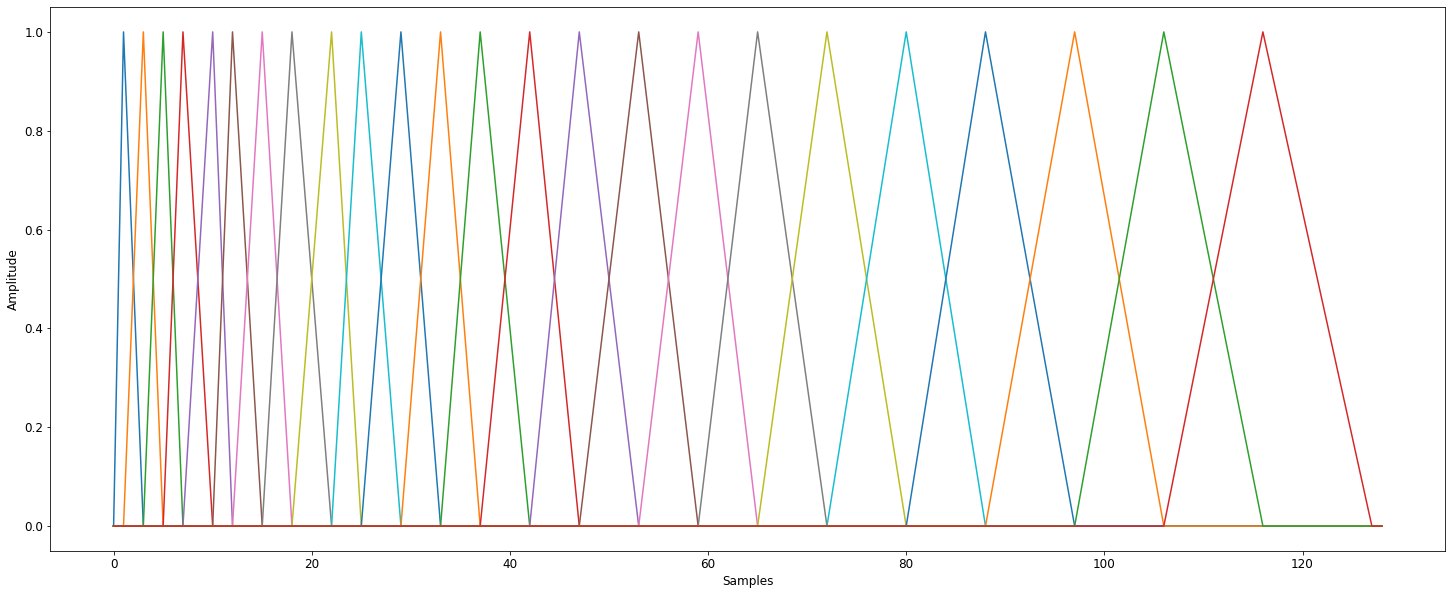

In [149]:
plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams.update({'font.size': 12})
for i in range(24):
    plt.plot(melb[i])
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

The function mfcc()

Mel spectrum
$$
s(m)=\sum_{k=0}^{N-1}\left[|X(k)|^{2} H_{m}(k)\right] ; \quad 0 \leq m \leq M-1
$$
where M is total number of triangular Mel weighting filters. H m (k) is the
weight given to the k th energy spectrum

The first n cepstral coefficients $C_k$ **(in general n is chosen between 10 and 15)** are calculated directly from the logarithm of the energies. 

The coefficient $C_0$ representing the average energy of the signal frame is often eliminated. It is eventually replaced by the logarithm of the total energy E calculated by the equation
$$
\mathrm{E}=\log \sum_{n=0}^{\mathrm{N}-1} \mathrm{~S}_{n}^{2}
$$
Which is normalized like this:
$$
\overline{\mathrm{E}}=0.1\left(\mathrm{E}-\mathrm{E}_{\max }\right)+1.0
$$

In [150]:
def mfcc(y, melb, nc):
    """
    Computing of the MFCC coefficients of a single frame

    Parameters
    ----------
    y : np.array
        The 1-dim. frame signal

    melb: np.array
        The 2-dim. mel-bank filters

    nc: int
        The number of coefficients

    Returns
    -------
    cc : np.array
        The 1-dim cepstral coefficients

    Examples
    --------
    >>> int16 = np.iinfo(np.int16)
    >>> rng = np.random.default_rng(0)
    >>> y = rng.integers(int16.min, int16.max, 256)
    >>> melb = melbank(nfilt=24, win_n=256, fs=8000)
    >>> cc = mfcc(y, melb, nc=13)
    >>> cc.shape
    (13,)
    """
    # compute the discrete fourier transform
    magnitude_spectrum = np.abs(fft.rfft(y)) # Magnitude of the FFT
    power = magnitude_spectrum ** 2  # Power Spectrum
    # multiplying the magnitude spectrum by each of the of the triangular Mel weighting filters.
    filter_banks=np.dot(melb, power)
    
    coef = fft.irfft(np.log(filter_banks))[1:nc]
    # coefficient C_0
    E = np.log(sum(y**2))
    E0 = np.max(E)
    NE = 0.1*(E - E0)+1.0
    return np.append(NE,coef)

In [151]:
int16 = np.iinfo(np.int16)
rng = np.random.default_rng(0)
y = rng.integers(int16.min, int16.max, 256)
melb = melbank(nfilt=24, win_n=256, fs=8000)
cc = mfcc(y, melb, nc=13)
cc.shape

(13,)

## Deltas and Delta-Deltas

The first-order derivative is called delta coefficients, and the second-order derivative is called delta–delta
coefficients. Delta coefficients tell about the speech rate, and delta–delta coeffi-
cients provide information similar to acceleration of speech. The commonly used
definition for computing dynamic parameter is

$$
\Delta C(t)=\frac{\sum_{i=1}^{\mathrm{N}_{\mathrm{T}}} i\left(\mathrm{C}_{t+i}-\mathrm{C}_{t-i}\right)}{2 \sum_{i=1}^{\mathrm{N}_{\mathrm{T}}} i^{2}}
$$

In [152]:
def delta(coef,N=1):
    """
    Compute delta features from a feature vector sequence.

    Parameters
    ----------
    coef :  A numpy array
            The 2-dim. (n_frames, nc) cepstral coefficients
    N : int 
            for each frame, calculate delta features 
        
    Returns
    -------
    c : A numpy array 
            The 2-dim. (num_frames, nc) cepstral differential features      
    """
    denominator = 2 * sum([i**2 for i in range(1,N+1)])
    delta_feat = np.empty_like(coef)
    padded = np.pad(coef,pad_width=((N,N),(0,0)), mode='edge')

    for t in range(len(coef)):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator
    return delta_feat

In [153]:
def wav2mfcc(fname, nc=13, nfilt=24, win=0.032, step=0.010):
    """
    Computing of the MFCC coefficients of a whole wave file
    
    Parameters
    ----------
    fname : str
        The filename of the wave file to process
    
    nc : int
        The number of cepstral coefficients
        
    nfilt : int
        The number of melbank filters
    
    win : int
        The window size (s)
    
    step : int
        The step size (s)

    Returns
    -------
    c : np.array
        The 2-dim cepstral coefficients of the whole file
    """
    
    signal, sample_rate = readwav(fname)
    
    # Pre-emphasis
    emphasized_signal = preemph(signal)
    
    # Audio Framing                                            
    frame_length = win * sample_rate
    frame_step = step * sample_rate
    
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
    
    padded_signal_length = num_frames * frame_step + frame_length
    
    z = np.zeros((padded_signal_length - signal_length))
    ppadded_signal = np.append(emphasized_signal, z)
    
    # Cepstral Coefficients
    Cepstral = np.empty([num_frames,nc])
    melb = melbank(nfilt=nfilt, win_n=frame_length, fs=sample_rate)

    ## Window
    Window = np.hamming(frame_length)   

    for i in range(num_frames):
        s = Window * ppadded_signal[frame_step*i:frame_step*i + frame_length] 
        cepstral_coef = mfcc(s, melb, nc)
        Cepstral[i] = cepstral_coef

    # Feature delta
    delta_feat = delta(Cepstral)

    # delta_delta_feat
    delta_delta_feat = delta(Cepstral,2)

    Cepstral = np.concatenate((Cepstral,delta_feat,delta_delta_feat))
 
    return Cepstral

In [154]:
def euclid(v1, v2):
    """    
    Computation of the Euclidean distance between the MFCC frames
        
    Parameters
    ----------
    v1 : np.array
        1-dim. MFCC frame
    
    v2 : np.array
        1-dim. MFCC frame

    Returns
    -------
    dist : int
        The Euclidean distance value
    """
    return np.linalg.norm(v1-v2)

The role of pre-emphasis is to increase the high frequencies. This is to match our perception of high frequencies.

In [155]:
def preemph(x, alpha=0.97):
    """
    (Optional)
    
    Applying the pre-emphasis step to the PCM audio signal:
    to decrease high frequency energy
        
    Parameters
    ----------
    x : np.array
        The 1-dim. PCM audio signal
    
    alpha : int 
        The pre-emphasis coefficient

    Returns
    -------
    x_pre : np.array
        The 1-dim. filtered audio signal
    """
    return np.append(x[0], x[1:] - alpha * x[:-1])

## Dynamic Time Warping

Dynamic Time Warping is an algorithm to measure the similarity between two time sequences whose frequency may vary.
DTW  algorithm  is implemented to calculate least distance between features of word  uttered  and  reference  templates. 

A matrix of order n by m is created whose (i, j) element is distance c  (ai,  bj)  between  points  aiand bj  of  two  time  sequences. Euclidean computation is used to measure distance between features of input sample and saved template. Then, distance is measured by

$$
D(i, j)=c\left(x_{i}, y_{i}\right)+\min \{D(i-1, j-1), D(i-1, j), D(i, j-1)\}
$$

In [156]:
def dtw(c1, c2):
    """    
    Computation of DTW between MFCC signals
        
    Parameters
    ----------
    c1 : np.array
        2-dim. MFCC signal
    
    c1 : np.array
        2-dim. MFCC signal

    Returns
    -------
    dist : int
        The DTW distance value
    """
    n_c1 = c1.shape[0]
    n_c2 = c2.shape[0]
    D = np.zeros([n_c1+1,n_c2+1])
    D[0,1:] = np.inf
    D[1:,0] = np.inf
    for i in range(1,n_c1+1):
        for j in range(1,n_c2+1):
            #local distance 
            d = euclid(c1[i-1],c2[j-1])
            D[i,j] = d + min([D[i,j-1], D[i-1,j], D[i-1,j-1]])
    return D[-1,-1]

# The computation script

In [157]:
trainDir = "./digits/train/"
testDir = "./digits/test/"
train_f = os.listdir(trainDir)
test_f = os.listdir(testDir)
train_mfcc = []
train_label = []
test_mfcc = []
test_label = []
for file_name in train_f:
        if file_name.endswith(".wav"):
            train_mfcc.append(wav2mfcc(trainDir + file_name))
            label = ''.join([n for n in file_name if n.isdigit()])
            if label == '':
                label = '0'
            train_label.append(label)
            
for file_name in test_f:
        if file_name.endswith(".wav"):
            test_mfcc.append(wav2mfcc(testDir + file_name))
            label = ''.join([n for n in file_name if n.isdigit()])
            if label == '':
                label = '0'
            test_label.append(label)

In [158]:
DTW_calculator = np.empty([len(test_mfcc),len(train_mfcc)])
for i in range(len(test_mfcc)):
    print('Tested file',i)
    for j in range(len(train_mfcc)):
        DTW_calculator[i,j] = dtw(test_mfcc[i],train_mfcc[j])
        if not j % 50:
            print('The comparison number',j)
    print('*************************')

Tested file 0
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 1
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 2
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 3
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 4
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 5
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
************************

*************************
Tested file 49
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 50
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 51
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 52
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 53
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison number 200
*************************
Tested file 54
The comparison number 0
The comparison number 50
The comparison number 100
The comparison number 150
The comparison num

The comparison number 200
*************************


In [163]:
index_min = np.argmin(DTW_calculator, axis=1)
prediction = []
prediction_label = []
for i in range(len(test_f)):
    prediction.append(train_f[index_min[i]])
    prediction_label.append(train_label[index_min[i]])

In [164]:
dict = {'Tested file ' : test_f, 
        'Pronounced number' : test_label, 
        'Predicted number' : prediction_label} 
df = pd.DataFrame(dict) 
display(df) 

Tested file  Pronounced number Predicted number
0     ah_4b.wav                 4                4
1     dj_3a.wav                 3                3
2     ed_zb.wav                 0                0
3     ed_4a.wav                 4                4
4     be_za.wav                 0                0
..          ...               ...              ...
93    at_2a.wav                 2                2
94    fg_1b.wav                 1                1
95    dj_8a.wav                 8                8
96    be_7b.wav                 7                7
97    fg_9a.wav                 9                9

[98 rows x 3 columns]

In [170]:

classified = len([i for i, j in zip(test_label, prediction_label) if i == j])
accuracy = len([i for i, j in zip(test_label, prediction_label) if i == j])/len(test_f)

print('The accuracy: ', accuracy)
print('The accuracy %: ', accuracy*100,'%')



The accuracy:  0.9591836734693877
The accuracy %:  95.91836734693877 %


In [162]:
doctest.testmod(optionflags=doctest.ELLIPSIS | doctest.NORMALIZE_WHITESPACE)

TestResults(failed=0, attempted=14)

## references 

- https://www.researchgate.net/publication/260762671_Speech_recognition_using_MFCC_and_DTW
- http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
- https://blog.groupe-sii.com/ral/
- https://arxiv.org/abs/1003.4083
- https://www.cs.unm.edu/~mueen/DTW.pdf